# Example use case: Hertzsprung-Russell diagrams

In this notebook we compute Hertzsprung-Russell diagrams (HRDs) of single and binary stars.


In [1]:
import os
import math
import matplotlib.pyplot as plt

from binarycpython.utils.functions import temp_dir
from binarycpython.utils.grid import Population

TMP_DIR = temp_dir("notebooks", "notebook_HRD")
VERBOSITY = 0

## Setting up the Population object
First we set up a new population object. Our stars evolve to $13.7\mathrm{Gyr}$, the age of the Universe, and we assume the metallicity $Z=0.02$. These are rough approximations: a real population was born some finite time ago, so cannot possibly evolve to $13.7\mathrm{Gyr}$, and stars are not really born with a metallicity of $0.02$. These approximations only affect very low mass stars, so we assume all our stars have mass $M\geq 1 \mathrm{M}_\odot$, and metallicity does not change evolution too much except in massive stars through the dependence of their winds on metallicity, so we limit our study to $M\leq 10 \mathrm{M}_\odot$.

In [2]:
# Create population object
population = Population(verbosity=VERBOSITY)

# Setting values can be done via .set(<parameter_name>=<value>)
# Values that are known to be binary_c_parameters are loaded into bse_options.
# Those that are present in the default grid_options are set in grid_options
# All other values that you set are put in a custom_options dict
population.set(
    # binary_c physics options
    max_evolution_time=13700,  # maximum stellar evolution time in Myr (13700 Myr == 13.7 Gyr)
    metallicity=0.02, # 0.02 is approximately Solar metallicity 
    tmp_dir=TMP_DIR,
)

## Stellar Grid
We now construct a grid of stars, varying the mass from $1$ to $10\mathrm{M}_\odot$ in nine steps (so the masses are integers). 

In [3]:
# Set resolution and mass range that we simulate
resolution = {"M_1": 9} 
massrange = (1, 11) 

population.add_grid_variable(
    name="M_1",
    longname="Primary mass", # == single-star mass
    valuerange=massrange,
    samplerfunc="self.const_linear({min_mass}, {max_mass}, {res_mass})".format(
        min_mass=massrange[0],
        max_mass=massrange[1],
        res_mass=resolution['M_1']
    ), # space by unit masses
    probdist="1", # dprob/dm1 : we don't care, so just set it to 1
    dphasevol="dM_1",
    parameter_name="M_1",
    condition="",  # Impose a condition on this grid variable. Mostly for a check for yourself
    gridtype="edge"
)

## Setting logging and handling the output

We now construct the HRD output.

We choose stars prior to and including the thermally-pulsing asymptotic giant branch (TPAGB) phase that have $>0.1\mathrm{M}_\odot$ of material in their outer hydrogen envelope (remember the core of an evolved star is made of helium or carbon/oxygen/neon). This prevents us showing the post-AGB phase which is a bit messy and we avoid the white-dwarf cooling track.

In [4]:
custom_logging_statement = """
Foreach_star(star)
{
    if(star->stellar_type <= TPAGB &&
       star->mass - Outermost_core_mass(star) > 0.1)
    {
         double logTeff = log10(Teff_from_star_struct(star));
         double logL = log10(star->luminosity); 
         double loggravity = log10(TINY+GRAVITATIONAL_CONSTANT*M_SUN*star->mass/Pow2(star->radius*R_SUN));
         Printf("HRD%d %30.12e %g %g %g %g\\n",
            star->starnum, // 0
            stardata->model.time, // 1
            stardata->common.zero_age.mass[0], // 2 : note this is the initial primary mass
            logTeff, // 3
            logL, // 4
            loggravity // 5
        );
    }
}
"""

population.set(
    C_logging_code=custom_logging_statement
)

The parse function must now catch lines that start with "HRD*n*", where *n* is 0 (primary star) or 1 (secondary star, which doesn't exist in single-star systems), and process the associated data.

In [5]:
from binarycpython.utils.functions import datalinedict
import re

def parse_function(self, output):
    """
    Parsing function to convert HRD data into something that Python can use
    """
    
    # list of the data items
    parameters = ["header", "time", "zams_mass", "logTeff", "logL", "logg"]
    
    # Loop over the output.
    for line in output.splitlines():
        match = re.search('HRD(\d)',line) 
        if match:
            nstar = match.group(1) 
            
            # obtain the line of data in dictionary form 
            linedata = datalinedict(line,parameters)
            
            # first time setup of the list of tuples
            if(len(self.grid_results['HRD'][nstar][linedata['zams_mass']])==0):
                self.grid_results['HRD'][nstar][linedata['zams_mass']] = []

            # make the HRD be a list of tuples
            self.grid_results['HRD'][nstar][linedata['zams_mass']].append((linedata['logTeff'],
                                                                           linedata['logL']))
    
    # verbose reporting
    #print("parse out results_dictionary=",self.grid_results)
    
# Add the parsing function
population.set(
    parse_function=parse_function,
)

## Evolving the grid
Now that we configured all the main parts of the population object, we can actually run the population! Doing this is straightforward: `population.evolve()`

This will start up the processing of all the systems. We can control how many cores are used by settings `num_cores`. By setting the `verbosity` of the population object to a higher value we can get a lot of verbose information about the run.

There are many grid_options that can lead to different behaviour of the evolution of the grid. Please do have a look at the [grid options docs] (https://ri0005.pages.surrey.ac.uk/binary_c-python/grid_options_descriptions.html) for more details.

In [6]:
# set number of threads
population.set(
    # verbose output at level 1 is sufficient    
    verbosity=VERBOSITY,
    # set number of threads (i.e. number of CPU cores we use)
    num_cores=1,
    # ensure only single stars are calculated
    multiplicity=1,
)

# Evolve the population - this is the slow, number-crunching step
analytics = population.evolve()

Do dry run? True
Doing dry run to calculate total starcount and probability
Grid has handled 8 stars with a total probability of 10
****************************
*          Dry run         *
*   Total starcount is 8   *
*  Total probability is 10 *
****************************

Do join of subprocesses ...
Joined subprocesses.
**********************************************************
*  Population-c98b63ab1b0346d9a1067fc08cb8dd00 finished! *
*              The total probability is 10.              *
*  It took a total of 0.81s to run 8 systems on 1 cores  *
*                   = 0.81s of CPU time.                 *
*              Maximum memory use 167.133 MB             *
**********************************************************

No failed systems were found in this run.
Do analytics
Added analytics to metadata


After the run is complete, some technical report on the run is returned. I stored that in `analytics`. As we can see below, this dictionary is like a status report of the evolution. Useful for e.g. debugging.

Text(0, 0.5, '$\\log_{10} (L/$L$_{☉})$')

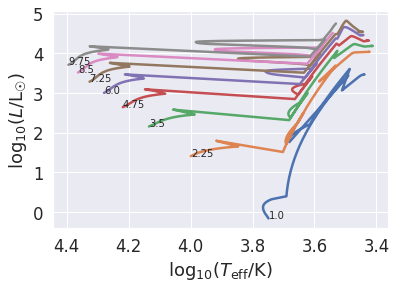

In [7]:
# make an HRD using Seaborn and Pandas
import seaborn as sns
import pandas as pd
from binarycpython.utils.functions import pad_output_distribution

hrd = population.grid_results['HRD']

#
pd.set_option("display.max_rows", None, "display.max_columns", None)

# set up seaborn for use in the notebook
sns.set(rc={'figure.figsize':(15, 12)})
sns.set_context("notebook",
                font_scale=1.5,
                rc={"lines.linewidth":2.5})

for nstar in sorted(hrd):
    for zams_mass in sorted(hrd[nstar]):
        # get track data (list of tuples)
        track = hrd[nstar][zams_mass]
        
        # convert to Pandas dataframe
        data = pd.DataFrame(data=track, 
                            columns = ['logTeff','logL'])
        
        # make seaborn plot
        p = sns.lineplot(data=data,
                         sort=False,
                         x='logTeff',
                         y='logL',
                         estimator=None)
        
        # set mass label at the zero-age main sequence (ZAMS) which is the first data point
        p.text(
            track[0][0],
            track[0][1],
            str(zams_mass)
        )
        
p.invert_xaxis()
p.set_xlabel("$\log_{10} (T_\mathrm{eff} / \mathrm{K})$")
p.set_ylabel("$\log_{10} (L/$L$_{☉})$")

We now have an HRD. It took longer to make the plot than to run the stars with *binary_c*!

## Binary stars

Now we put a secondary star of mass $0.5\mathrm{M}_\odot$ at a distance of $10\mathrm{R}_\odot$ to see how this changes things. Then we rerun the population. At such short separations, we expect mass transfer to begin on or shortly after the main sequence.

In [8]:
population.set(
    M_2 = 0.5, # Msun
    separation = 10, # Rsun
    multiplicity = 2, # binaries
)
population.clean()
analytics = population.evolve()  

Do dry run? True
Doing dry run to calculate total starcount and probability
Grid has handled 8 stars with a total probability of 10
****************************
*          Dry run         *
*   Total starcount is 8   *
*  Total probability is 10 *
****************************

Do join of subprocesses ...
Joined subprocesses.
**********************************************************
*  Population-8af9954e2cc847aa8ceabc618e3d147d finished! *
*              The total probability is 10.              *
*  It took a total of 1.13s to run 8 systems on 1 cores  *
*                   = 1.13s of CPU time.                 *
*              Maximum memory use 235.496 MB             *
**********************************************************

No failed systems were found in this run.
Do analytics
Added analytics to metadata


star  0.0
zams mass  1.0
zams mass  2.25
zams mass  3.5
zams mass  4.75
zams mass  6.0
zams mass  7.25
zams mass  8.5
zams mass  9.75
star  1.0


Text(0, 0.5, '$\\log_{10} (L/$L$_{☉})$')

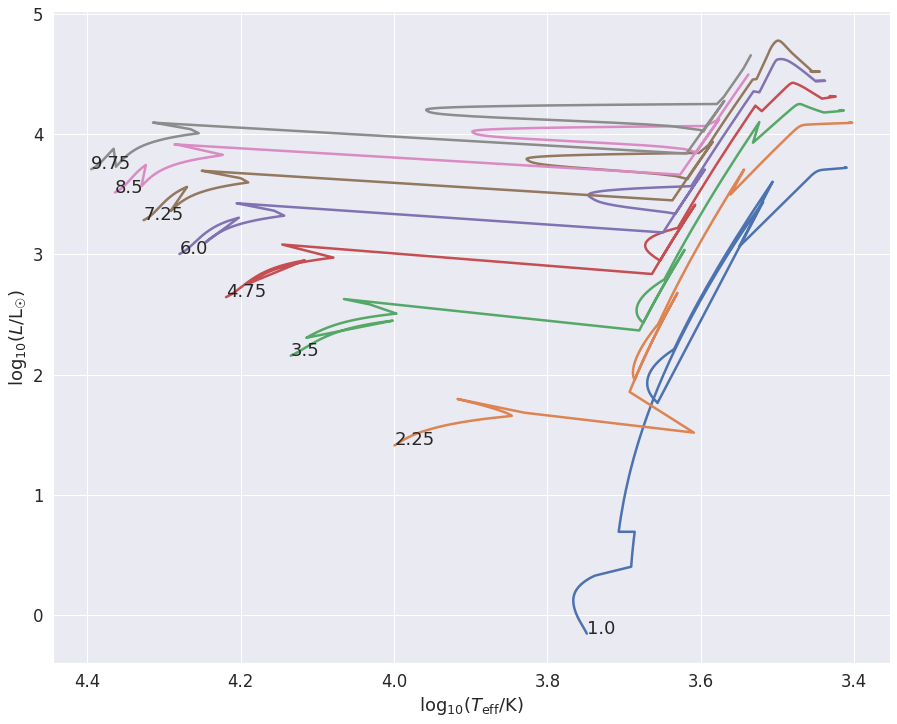

In [9]:
hrd = population.grid_results['HRD']

# set up seaborn for use in the notebook
sns.set(rc={'figure.figsize':(15, 12)})
sns.set_context("notebook",
                font_scale=1.5,
                rc={"lines.linewidth":2.5})

for nstar in sorted(hrd):
    print("star ",nstar)
    
    if nstar == 0: # choose only primaries

        for zams_mass in sorted(hrd[nstar]):
            print("zams mass ",zams_mass)
        
            # get track data (list of tuples)
            track = hrd[nstar][zams_mass]
        
            # convert to Pandas dataframe
            data = pd.DataFrame(data=track, 
                                columns = ['logTeff','logL'])

            # make seaborn plot
            p = sns.lineplot(data=data,
                             sort=False,
                             x='logTeff',
                             y='logL',
                             estimator=None)

            # set mass label at the zero-age main sequence (ZAMS) which is the first data point
            p.text(track[0][0],track[0][1],str(zams_mass))

p.invert_xaxis()
p.set_xlabel("$\log_{10} (T_\mathrm{eff} / \mathrm{K})$")
p.set_ylabel("$\log_{10} (L/$L$_{☉})$")

We plot here the track for the primary star only. You can see immediately where stars merge on the main sequence: the tracks move very suddenly where usually evolution on the main sequence is smooth.

If we now set the separation to be longer, say $100\mathrm{R}_\odot$, mass transfer should happen on the giant branch. We also set the secondary mass to be larger, $1\mathrm{M}_\odot$, so that the interaction is stronger.

In [10]:
population.set(
    M_2 = 1, # Msun
    separation = 100, # Rsun
    multiplicity = 2, # binaries
    alpha_ce = 1.0, # make common-envelope evolution quite efficient
)
population.clean()
analytics = population.evolve()

Do dry run? True
Doing dry run to calculate total starcount and probability
Grid has handled 8 stars with a total probability of 10
****************************
*          Dry run         *
*   Total starcount is 8   *
*  Total probability is 10 *
****************************

Do join of subprocesses ...
Joined subprocesses.
**********************************************************
*  Population-a34e3c842d96496c87ab0d70bdacac11 finished! *
*              The total probability is 10.              *
*  It took a total of 1.65s to run 8 systems on 1 cores  *
*                   = 1.65s of CPU time.                 *
*              Maximum memory use 247.824 MB             *
**********************************************************

No failed systems were found in this run.
Do analytics
Added analytics to metadata


Text(0, 0.5, '$\\log_{10} (L/$L$_{☉})$')

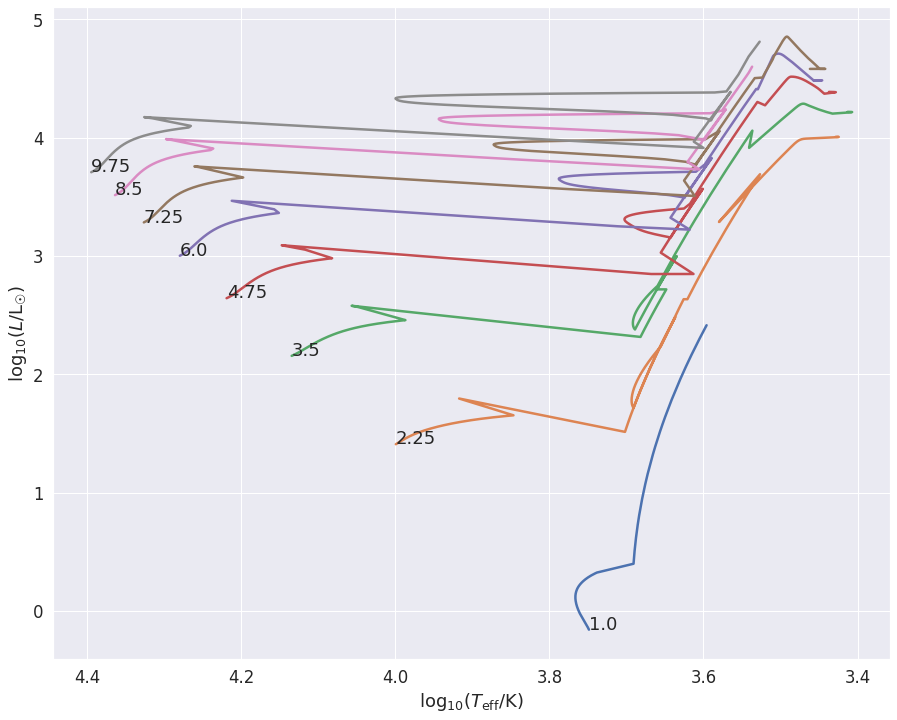

In [11]:
hrd = population.grid_results['HRD']

for nstar in sorted(hrd):
    if nstar == 0: # choose only primaries
        for zams_mass in sorted(hrd[nstar]):        
            # get track data (list of tuples)
            track = hrd[nstar][zams_mass]
        
            # convert to Pandas dataframe
            data = pd.DataFrame(data=track, 
                                columns = ['logTeff','logL'])
        
            # make seaborn plot
            p = sns.lineplot(data=data,
                             sort=False,
                             x='logTeff',
                             y='logL',
                             estimator=None)

            # set mass label at the zero-age main sequence (ZAMS) which is the first data point
            p.text(track[0][0],track[0][1],str(zams_mass))

p.invert_xaxis()
p.set_xlabel("$\log_{10} (T_\mathrm{eff} / \mathrm{K})$")
p.set_ylabel("$\log_{10} (L/$L$_{☉})$")

You now see the interaction in the jerky red-giant tracks where the stars interact. These probably, depending on the mass ratio at the moment of interaction, go through a common-envelope phase. The system can merge (most of the above do) but not all. The interaction is so strong on the RGB of the $1\mathrm{M}_\odot$ star that the stellar evolution is terminated before it reaches the RGB tip, so it never ignites helium. This is how helium white dwarfs are probably made.

We can also plot the secondary stars' HRD. Remember, the primary is star 0 in binary_c, while the secondary is star 1. That's because all proper programming languages start counting at 0. We change the parsing function a little so we can separate the plots of the secondaries according to their primary mass.

Text(0, 0.5, '$\\log_{10} (L/$L$_{☉})$')

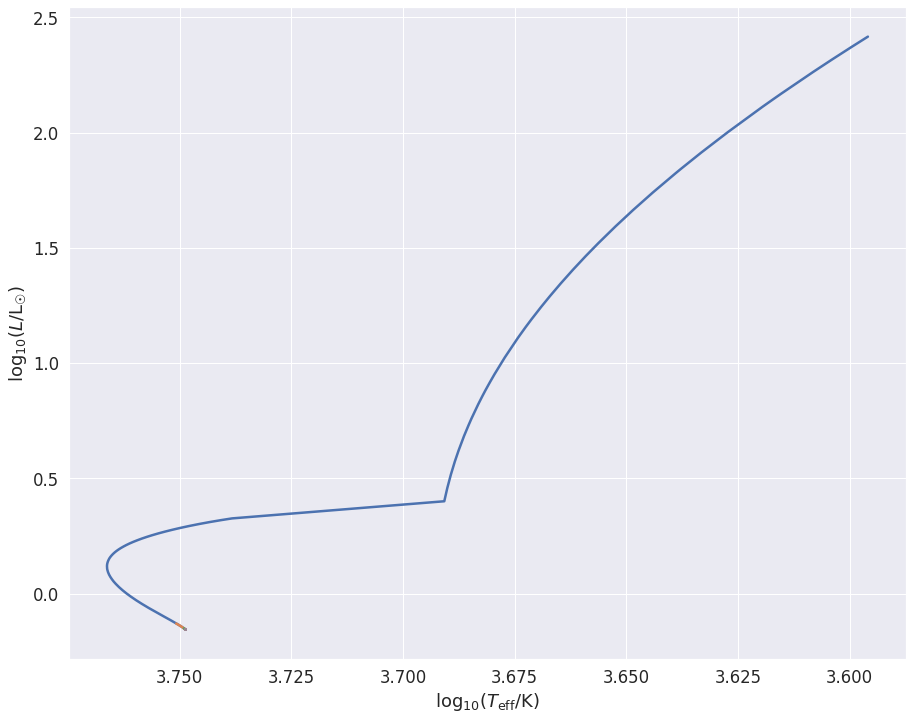

In [12]:
hrd = population.grid_results['HRD']

# set up seaborn for use in the notebook
sns.set(rc={'figure.figsize':(15, 12)})
sns.set_context("notebook",
                font_scale=1.5,
                rc={"lines.linewidth":2.5})

for nstar in sorted(hrd):
    if nstar == 1.0: # choose only secondaries
        for zams_mass in sorted(hrd[nstar]):       
            # get track data (list of tuples)
            track = hrd[nstar][zams_mass]

            # convert to Pandas dataframe
            data = pd.DataFrame(data=track, 
                                columns = ['logTeff','logL'])
            
            # make seaborn plot
            p = sns.lineplot(data=data,
                             sort=False,
                             x='logTeff',
                             y='logL',
                             estimator=None)


p.invert_xaxis()
p.set_xlabel("$\log_{10} (T_\mathrm{eff} / \mathrm{K})$")
p.set_ylabel("$\log_{10} (L/$L$_{☉})$")

Remember, all these stars start with a $1\mathrm{M}_\odot$ binary, which begins at $\log_{10}(T_\mathrm{eff}/\mathrm{K})\sim 3.750$, $\log_{10}L/\mathrm{L}_\odot \sim 0$. The $1\mathrm{M}_\odot$-$1\mathrm{M}_\odot$ binary evolves like two single stars until they interact up the giant branch at about $\log_{10} (L/\mathrm{L}_\odot) \sim 2.5$, the others interact long before they evolve very far on the main sequence: you can just about see their tracks at the very start.

This is, of course, a very simple introduction to what happens in binaries. We haven't talked about the remnants that are produced by interactions. When the stars do evolve on the giant branch, white dwarfs are made which can go on to suffer novae and (perhaps) thermonuclear explosions. The merging process itself leads to luminous red novae and, in the case of neutron stars and black holes, kilonovae and gravitational wave events. 